# ASTR 598 Astrostatistics
## HW2 Part 3
## Hayden Smotherman, Chris Suberlack, Winnie Wang
## To run this Notebook:

The Galfast data must be extracted from the projects/ directory as a .txt file and this notebook must be run in the  homeworks/group2/HW_2/ directory.

In [1]:
# Imports 
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
from astropy.table import vstack
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os
import numpy as np
from astropy.io import fits
import pandas as pd
from scipy.stats import binned_statistic_2d as bs2d 
from scipy.stats import binned_statistic as bs1d
import seaborn as sns

In [8]:
GalFastData = np.loadtxt('../../../project/Galfast-Stripe82.txt',usecols=(0,1,3,5,12,13,14))
GalFastTable = Table(rows=GalFastData, names=('ra','dec','pmra','pmdec','gmag','rmag','imag'))

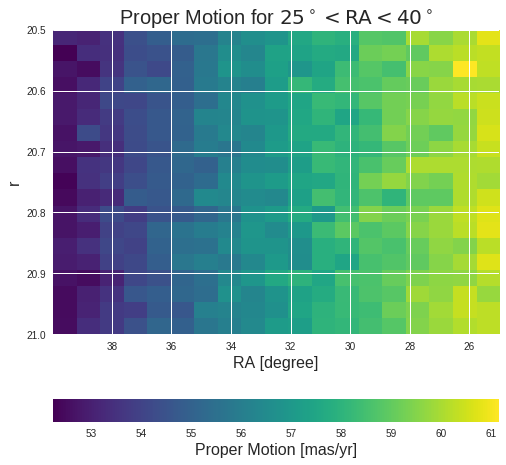

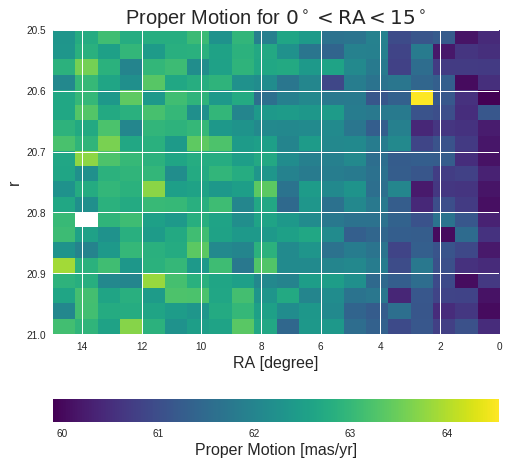

In [22]:
# Generate the magnitude mask used in the Hess diagram data analysis
def Hess_r_v_gminusi(aptable,total_mask):
    constant = 3 # This is a fudge parameter in determining number of bins
    nObjects = np.sum(total_mask)
    num_bins = int(constant * nObjects ** (1.0 / 4.0))

    # Now calculate the binned proper motions
    proper_motion = np.sqrt(aptable['pmra']**2+aptable['pmdec']**2)
    total_mask = proper_motion<100*total_mask
    Binned_PM = bs2d(aptable['ra'][total_mask],aptable['rmag'][total_mask],proper_motion[total_mask], bins = num_bins)


    #cmin = min(np.log10(Binned_PM.statistic.T[Binned_PM.statistic.T >  0]))
    #cmax = max(np.log10(Binned_PM.statistic.T[Binned_PM.statistic.T >  0]))

    # Define custom colormaps: Set pixels with no sources to white
    cmap = plt.cm.viridis
    cmap.set_bad('w', 1.)

    plt.figure(figsize=[8,8])
    plt.imshow(Binned_PM.statistic.T, origin='lower',
                   extent=[Binned_PM.x_edge[0], Binned_PM.x_edge[-1], Binned_PM.y_edge[0], Binned_PM.y_edge[-1]],
                   aspect='auto', interpolation='nearest', cmap=cmap)

    cb = plt.colorbar(orientation='horizontal')
    cb.set_label(r'Proper Motion [mas/yr]',fontsize=16)
    #plt.clim(0, 30) # This was set by hand to draw out as much detail as possible

    plt.xlabel(r'RA [degree]',fontsize=16)
    plt.ylabel(r'r',fontsize=16)
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()

# Make the color masks
r_mask = (GalFastTable['rmag']>20.5) & (GalFastTable['rmag']<21)
gminusi_mask = ((GalFastTable['gmag']-GalFastTable['imag']) > 0.3) & ((GalFastTable['gmag']-GalFastTable['imag']) < 0.4)
mag_mask = r_mask * gminusi_mask

# Make the RA Masks
RA_mask_25to40 = (GalFastTable['ra'] > 25) & (GalFastTable['ra'] < 40)
RA_mask_0to15 = (GalFastTable['ra'] > 0) & (GalFastTable['ra'] < 15)

# Make the net masks
mask_25to40 = mag_mask * RA_mask_25to40
mask_0to15 = mag_mask * RA_mask_0to15

# Make the Hess diagram for 25 < RA < 40
Hess_r_v_gminusi(GalFastTable,mask_25to40)
plt.title(r'Proper Motion for $25^\circ < \mathrm{RA} < 40^\circ$',fontsize=20)
plt.savefig('GalFast_pm_Hess_Diagram_RA25to40') # Save the figure

# Make the Hess diagram for 0 < RA < 15
Hess_r_v_gminusi(GalFastTable,mask_0to15)
plt.title(r'Proper Motion for $0^\circ < \mathrm{RA} < 15^\circ$',fontsize=20)
plt.savefig('GalFast_pm_Hess_Diagram_RA0to15') # Save the figure


The Galfast data is consistent with the NSC data in the stripe 82 region. The Galfast data shows a strong proper motion bimoodaility for stars in $25^\circ < \mathrm{RA} < 40^\circ$ while it shows little to no bimodality for stars in $0^\circ < \mathrm{RA} < 15^\circ$. Note that the color bar scale is different for each image. This mirrors what we saw in the NSC data in the same region, although the NSC dataset is too sparse to fully flesh-out the diagram.

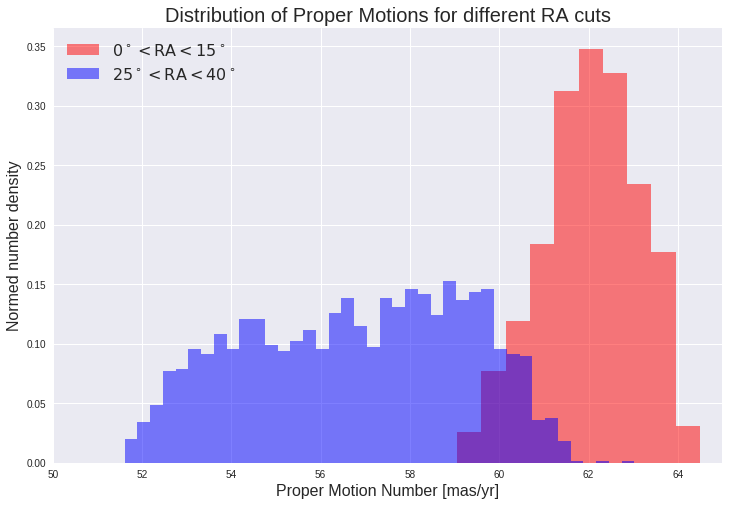

In [21]:
def ProperMotionHist(aptable,mask_noRAcuts,normed='True'):
    # This function makes a histogram of RA Proper motions for two different RA cuts
    
    # Calculate the total Proper Motion
    proper_motion = np.sqrt(aptable['pmra']**2+aptable['pmdec']**2)
    mask_noRAcuts = proper_motion<100*mask_noRAcuts
    
    # Make two masks that have the RA cuts included
    RA_mask_0to15 = (aptable['ra'] > 0) & (aptable['ra'] < 15)
    RA_mask_25to40 = (aptable['ra'] > 25) & (aptable['ra'] < 40)
    mask_0to15 = mask_noRAcuts * RA_mask_0to15
    mask_25to40 = mask_noRAcuts * RA_mask_25to40
    
    #Plot the two distributions with different RA cuts
    plt.figure(figsize=[12,8])
    plt.hist(proper_motion[mask_0to15],alpha=0.5,bins=40,normed=normed,linewidth=3,color='r')
    plt.hist(proper_motion[mask_25to40],alpha=0.5,bins=40,normed=normed,linewidth=3,color='b')

    plt.legend([r'$0^\circ < \mathrm{RA} < 15^\circ$',r'$25^\circ < \mathrm{RA} < 40^\circ$'],fontsize=16)
    plt.title('Distribution of Proper Motions for different RA cuts',fontsize=20)
    plt.xlabel('Proper Motion Number [mas/yr]',fontsize=16)
    plt.ylabel('Normed number density',fontsize=16)
    plt.xlim([50,65])
    #plt.ylim([1,200])
    
# Make some universal cuts
r_mask = (GalFastTable['rmag']>20.5) & (GalFastTable['rmag']<21)
gminusi_mask = ((GalFastTable['gmag']-GalFastTable['imag']) > 0.3) & ((GalFastTable['gmag']-GalFastTable['imag']) < 0.4)
mag_mask = r_mask * gminusi_mask

ProperMotionHist(GalFastTable,mag_mask)

Here, we see a very distinct difference in proper motions between the $25^\circ < \mathrm{RA} < 40^\circ$ region and $0^\circ < \mathrm{RA} < 15^\circ$ region. This is *NOT* mirrored in the NSC data, nor are the proper motion values consistent. NSC data has most stars with proper motions of $0 \ \mathrm{[mas/yr]} < \mathrm{PM} < 30 \ \mathrm{ [mas/yr]}$.